# Species distribution modeling with multimodal data

## 1. Setup

### 1.1 Install dependencies

In [2]:
!pip install -U -q torch==2.5.0 torchvision matplotlib tqdm gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 820.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install scikit-multilearn
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.3 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, label_ranking_loss, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

### 1.2 Check if cuda available

In [5]:
print(torch.cuda.is_available())

True


## 2. Data loading

### 2.1 Mounting drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.1 Downloading data

In [ ]:
base_path = "/content/drive/MyDrive/IPEO_Species_Distribution_Modeling/"

os.chdir(base_path)
os.getcwd()

'/content/drive/MyDrive/IPEO/Project'

In [ ]:
env_train = pd.read_csv(base_path + "data/env_variables_training.csv")
env_test  = pd.read_csv(base_path + "data/env_variables_test.csv")

ts_train  = pd.read_csv(base_path + "data/landsat_timeseries_training.csv")
ts_test   = pd.read_csv(base_path + "data/landsat_timeseries_test.csv")

# ---- Numpy files ----
img_train = np.load(base_path + "data/satellite_patches_training.npy")
img_test  = np.load(base_path + "data/satellite_patches_test.npy")

species_train = np.load(base_path + "data/species_data_training.npy")
species_test  = np.load(base_path + "data/species_data_test.npy")

print("Training shapes:")
print("Env:", env_train.shape)
print("Time-series:", ts_train.shape)
print("Images:", img_train.shape)
print("Labels:", species_train.shape)

Training shapes:
Env: (5000, 22)
Time-series: (5000, 161)
Images: (5000, 3, 128, 128)
Labels: (5000, 342)


### 2.2 Reshaping and removing columns

In [9]:
# Extract coordinates
train_lons = env_train.iloc[:, 1]
train_lats = env_train.iloc[:, 2]
test_lons = env_test.iloc[:, 1]
test_lats = env_test.iloc[:, 2]

env_train = env_train.values.astype(np.float32)
env_test  = env_test.values.astype(np.float32)

env_train = env_train[:, 3:]
env_test  = env_test[:, 3:]

mean_env = env_train.mean(axis=0)
std_env = env_train.std(axis=0)
env_train = (env_train - mean_env) / std_env
env_test = (env_test - mean_env) / std_env


ts_train = ts_train.values.astype(np.float32)
ts_test  = ts_test.values.astype(np.float32)

ts_train = ts_train[:, 1:161].reshape(-1, 40, 4)
ts_test  = ts_test[:, 1:161].reshape(-1, 40, 4)

mean_ts = ts_train.mean(axis=(0, 1))
std_ts = ts_train.std(axis=(0, 1))
ts_train = (ts_train - mean_ts) / std_ts
ts_test = (ts_test - mean_ts) / std_ts


img_train = img_train.astype(np.float32)/255.0
img_test  = img_test.astype(np.float32)/255.0

species_train = species_train.astype(np.float32)
species_test  = species_test.astype(np.float32)

### 2.3 Defining dataset class

In [10]:
class GeoPlantDataset(Dataset):
    def __init__(self, images, timeseries, tabular, labels, split='train', val_split=0.2, random_state=42):
        """
        Args:
            images: numpy array of satellite images
            timeseries: numpy array of time series data
            tabular: numpy array of environmental variables
            labels: numpy array of species labels
            split: 'train', 'val', or 'test'
            val_split: fraction of training data to use for validation (default 0.2)
            random_state: random seed for reproducibility
        """
        self.split = split

        if split == 'test' or split is None:
            self.images = images
            self.timeseries = timeseries
            self.tabular = tabular
            self.labels = labels
        else:
            indices = np.arange(len(labels))
            train_idx, val_idx = train_test_split(
                indices,
                test_size=val_split,
                random_state=random_state
            )

            if split == 'train':
                self.images = images[train_idx]
                self.timeseries = timeseries[train_idx]
                self.tabular = tabular[train_idx]
                self.labels = labels[train_idx]
            elif split == 'val':
                self.images = images[val_idx]
                self.timeseries = timeseries[val_idx]
                self.tabular = tabular[val_idx]
                self.labels = labels[val_idx]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx])
        ts  = torch.tensor(self.timeseries[idx])
        tab = torch.tensor(self.tabular[idx])
        y   = torch.tensor(self.labels[idx])
        return img, ts, tab, y

### 2.4 Creating dataset

In [11]:
train_dataset = GeoPlantDataset(
    images=img_train,
    timeseries=ts_train,
    tabular=env_train,
    labels=species_train,
    split='train',
    val_split=0.2
)

val_dataset = GeoPlantDataset(
    images=img_train,
    timeseries=ts_train,
    tabular=env_train,
    labels=species_train,
    split='val',
    val_split=0.2
)

test_dataset = GeoPlantDataset(
    images=img_test,
    timeseries=ts_test,
    tabular=env_test,
    labels=species_test,
    split='test'
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 4000
Val samples: 1000
Test samples: 1000


### 2.5 Checking dimensions

In [12]:
img, ts, tab, y = train_dataset[0]

print("Image:", img.shape)
print("Time series:", ts.shape)
print("Tabular:", tab.shape)
print("Label:", y.shape)

Image: torch.Size([3, 128, 128])
Time series: torch.Size([40, 4])
Tabular: torch.Size([19])
Label: torch.Size([342])


## 3. Multimodal species distribution model

In [19]:
# ------------------------------------------------------------
# 3.1 TABULAR ENCODER (climate variables)
# ------------------------------------------------------------
class TabularEncoder(nn.Module):
    def __init__(self, in_features=19, out_features=342):
        super().__init__()
        self.net = nn.Sequential(
          nn.Linear(in_features, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Dropout(0.1),

          nn.Linear(64, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(0.2),

          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(0.3),

          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


# ------------------------------------------------------------
# 3.2 TEMPORAL ENCODER (Landsat quarterly 10-year series)
#      Input shape: (batch, T=40, C=4)
# ------------------------------------------------------------
class TimeseriesEncoder(nn.Module):
    def __init__(self, in_channels=4, out_features=342):
        super().__init__()

        # Convolutional Backbone
        self.features = nn.Sequential(
            self._make_layer(in_channels, 32),
            self._make_layer(32, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
            self._make_layer(256, 512),
        )

        # Pooling
        self.pool = nn.AdaptiveAvgPool1d(1)

        # Dropout
        self.dropout = nn.Dropout(0.2)


    def _make_layer(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv1d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_c), # Added for stability
            nn.ReLU()
        )


    def forward(self, ts):
        # ts shape: (B, T, C) -> (B, C, T)
        ts = ts.permute(0, 2, 1)

        x = self.features(ts)

        # Global Average Pool: (B, 512, T) -> (B, 512)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return x


# ------------------------------------------------------------
# 3.3 IMAGE ENCODER (Sentinel-2 RGB patches)
#      Uses pretrained ResNet34 but outputs a 256-dim feature
# ------------------------------------------------------------
from torchvision.models import resnet34

class ImageEncoder(nn.Module):
    def __init__(self, num_species=342):
        super().__init__()
        # Load weights suited for natural images
        base = resnet34(weights="DEFAULT")

        # Keep everything except final FC layer
        self.backbone = nn.Sequential(*list(base.children())[:-1])

        # Add FC
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

    def forward(self, img):
        features = self.backbone(img)
        x = self.head(features)
        return x

# ------------------------------------------------------------
# 3.4 FUSION MODEL
# ------------------------------------------------------------
class MultimodalSpeciesModel(nn.Module):
    def __init__(self, num_species=342):
        super().__init__()
        self.image   = ImageEncoder()
        self.temporal = TimeseriesEncoder()
        self.tabular = TabularEncoder()

        fusion_dim = 3*512
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim,1536),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1536,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_species)
        )

    def forward(self, img, ts, tab):
        f_img = self.image(img)
        f_ts  = self.temporal(ts)
        f_tab = self.tabular(tab)

        fused = torch.cat([f_img, f_ts, f_tab], dim=1)
        logits = self.fusion(fused)
        return logits


# instantiate the model
model = MultimodalSpeciesModel()
print("Multimodal model created with parameters:", sum(p.numel() for p in model.parameters()))


Multimodal model created with parameters: 26884022


## 4. Training the model

### 4.1 Training one epoch

In [14]:
def train_epoch(model, loader, optimizer, criterion, device='cpu'):
    model.train()
    running_loss = 0.0
    samples_processed = 0

    for img, ts, tab, y in loader:
        img = img.to(device).float()
        ts = ts.to(device).float()
        tab = tab.to(device).float()
        y = y.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        logits = model(img, ts, tab)
        loss = criterion(logits, y)

        # Backward pass
        loss.backward()

        # Gradient Clipping (Focal loss)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Accurate accumulation
        batch_size = tab.size(0)
        running_loss += loss.item() * batch_size
        samples_processed += batch_size

    return running_loss / samples_processed

### 4.2 Evaluation of the model

In [20]:
def evaluate(model, loader, criterion, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    samples_processed = 0

    with torch.no_grad():
        for img, ts, tab, y in loader:
            img = img.to(device).float()
            ts = ts.to(device).float()
            tab = tab.to(device).float()
            y = y.to(device).float()

            # Forward pass (ONLY ONCE)
            logits = model(img, ts, tab)

            # Loss (use logits directly)
            loss = criterion(logits, y)

            batch_size = y.size(0)
            running_loss += loss.item() * batch_size
            samples_processed += batch_size

            # Probabilities for metrics
            probs = torch.sigmoid(logits)

            all_preds.append(probs.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Robust AUC
    try:
        macro_auc = roc_auc_score(all_labels, all_preds, average='macro')
    except ValueError:
        macro_auc = 0.0
        print("Warning: Some classes had no positive samples in this fold.")

    # Average Precision
    macro_avg_prec = average_precision_score(
        all_labels, all_preds, average='macro'
    )

    avg_loss = running_loss / samples_processed

    return macro_auc, macro_avg_prec, avg_loss

### 4.3 Calculate species weights (for param alpha in focal loss function)

In [16]:
counts = species_train.sum(axis=0)
total_samples = len(species_train)

weights = total_samples / (counts + 1e-5)

weights = weights / weights.mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
species_weights = torch.tensor(weights, dtype=torch.float).to(device)

### 4.4 Focal loss function

In [17]:
class MultiLabelFocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(MultiLabelFocalLoss, self).__init__()
        self.gamma = gamma

        # Parameter alpha can be a float or a tensor of shape (num_classes,)
        self.alpha = alpha

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        # Compute p_t (probability of ground truth)
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)

        # Modulating factor (Focal component)
        focal_weight = (1 - p_t) ** self.gamma

        # Corrected Alpha Balancing for Multi-Label
        if isinstance(self.alpha, torch.Tensor):
            alpha_pos = self.alpha
            alpha_neg = 1 - 0.25 # Keep negative weight constant and small
            alpha_weight = targets * alpha_pos + (1 - targets) * alpha_neg
        else:
            # Standard scalar behavior
            alpha_weight = targets * self.alpha + (1 - targets) * (1 - self.alpha)

        loss = alpha_weight * focal_weight * bce_loss

        return loss.mean()

### 4.5 K-fold cross validation


--- Starting Fold 1/5 ---
  --> Epoch 1: Best AUC Updated: 0.6278
Epoch 1 Train_loss: 0.0309 | Val_Loss: 0.0263 | Val_AUC: 0.6278| Val_avg_prec: 0.0722
  --> Epoch 2: Best AUC Updated: 0.6910
Epoch 2 Train_loss: 0.0265 | Val_Loss: 0.0265 | Val_AUC: 0.6910| Val_avg_prec: 0.0891
  --> Epoch 3: Best AUC Updated: 0.7610
Epoch 3 Train_loss: 0.0254 | Val_Loss: 0.0241 | Val_AUC: 0.7610| Val_avg_prec: 0.1263
  --> Epoch 4: Best AUC Updated: 0.7784
Epoch 4 Train_loss: 0.0244 | Val_Loss: 0.0231 | Val_AUC: 0.7784| Val_avg_prec: 0.1335
  --> Epoch 5: Best AUC Updated: 0.8059
Epoch 5 Train_loss: 0.0236 | Val_Loss: 0.0224 | Val_AUC: 0.8059| Val_avg_prec: 0.1602
  --> Epoch 6: Best AUC Updated: 0.8201
Epoch 6 Train_loss: 0.0231 | Val_Loss: 0.0217 | Val_AUC: 0.8201| Val_avg_prec: 0.1680
  --> Epoch 7: Best AUC Updated: 0.8211
Epoch 7 Train_loss: 0.0226 | Val_Loss: 0.0221 | Val_AUC: 0.8211| Val_avg_prec: 0.1691
  --> Epoch 8: Best AUC Updated: 0.8338
Epoch 8 Train_loss: 0.0224 | Val_Loss: 0.0212 | Val

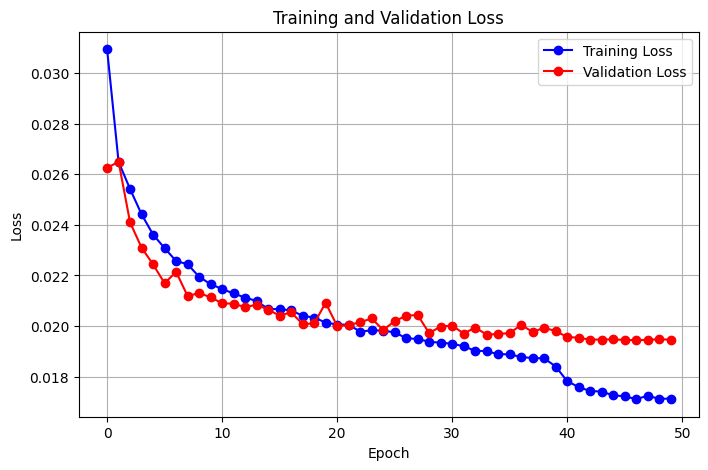

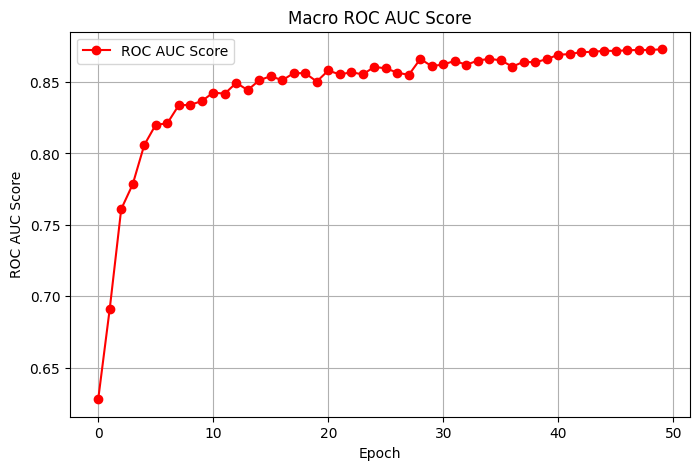

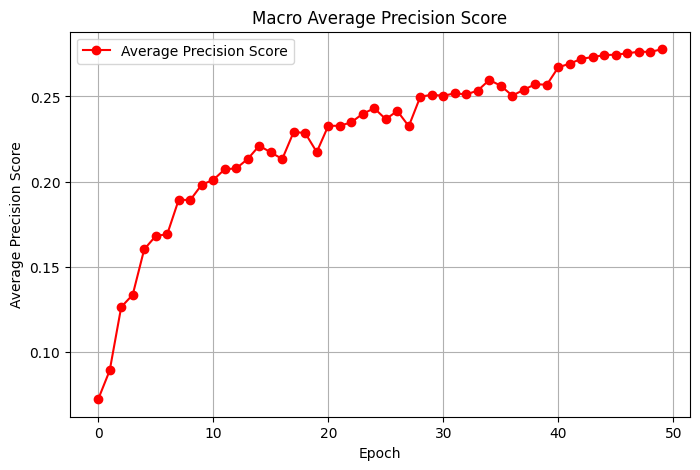


--- Starting Fold 2/5 ---
  --> Epoch 1: Best AUC Updated: 0.6600
Epoch 1 Train_loss: 0.0307 | Val_Loss: 0.0254 | Val_AUC: 0.6600| Val_avg_prec: 0.0798
  --> Epoch 2: Best AUC Updated: 0.6949
Epoch 2 Train_loss: 0.0265 | Val_Loss: 0.0248 | Val_AUC: 0.6949| Val_avg_prec: 0.0994
  --> Epoch 3: Best AUC Updated: 0.7379
Epoch 3 Train_loss: 0.0261 | Val_Loss: 0.0238 | Val_AUC: 0.7379| Val_avg_prec: 0.1152
  --> Epoch 4: Best AUC Updated: 0.7495
Epoch 4 Train_loss: 0.0247 | Val_Loss: 0.0243 | Val_AUC: 0.7495| Val_avg_prec: 0.1213
  --> Epoch 5: Best AUC Updated: 0.7741
Epoch 5 Train_loss: 0.0242 | Val_Loss: 0.0228 | Val_AUC: 0.7741| Val_avg_prec: 0.1418
Epoch 6 Train_loss: 0.0233 | Val_Loss: 0.0247 | Val_AUC: 0.7485| Val_avg_prec: 0.1376
  --> Epoch 7: Best AUC Updated: 0.8173
Epoch 7 Train_loss: 0.0227 | Val_Loss: 0.0218 | Val_AUC: 0.8173| Val_avg_prec: 0.1713
  --> Epoch 8: Best AUC Updated: 0.8216
Epoch 8 Train_loss: 0.0223 | Val_Loss: 0.0215 | Val_AUC: 0.8216| Val_avg_prec: 0.1863
  -->

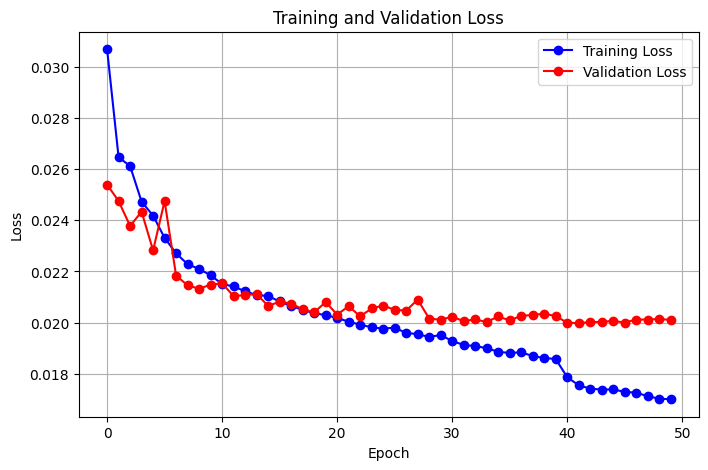

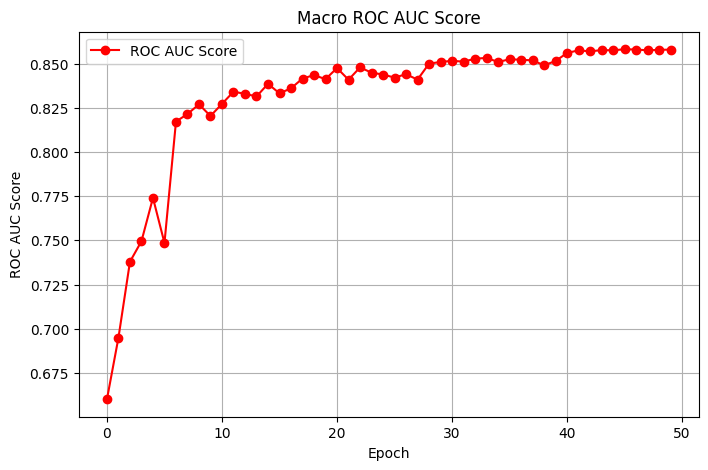

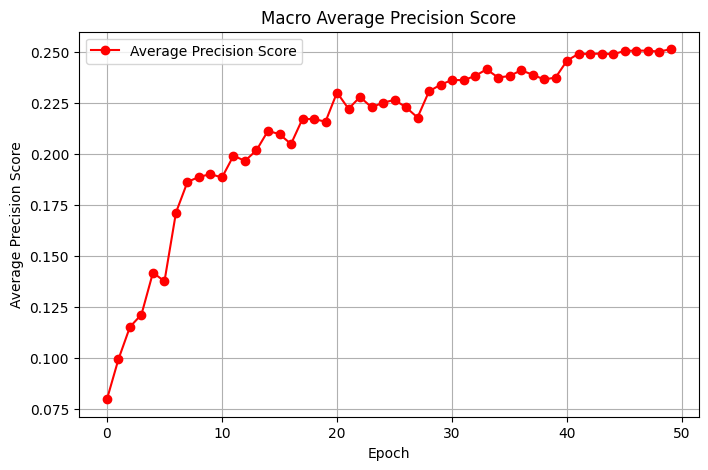


--- Starting Fold 3/5 ---
  --> Epoch 1: Best AUC Updated: 0.6003
Epoch 1 Train_loss: 0.0310 | Val_Loss: 0.0273 | Val_AUC: 0.6003| Val_avg_prec: 0.0658
  --> Epoch 2: Best AUC Updated: 0.6960
Epoch 2 Train_loss: 0.0269 | Val_Loss: 0.0253 | Val_AUC: 0.6960| Val_avg_prec: 0.0895
  --> Epoch 3: Best AUC Updated: 0.7573
Epoch 3 Train_loss: 0.0257 | Val_Loss: 0.0241 | Val_AUC: 0.7573| Val_avg_prec: 0.1242
  --> Epoch 4: Best AUC Updated: 0.7863
Epoch 4 Train_loss: 0.0244 | Val_Loss: 0.0232 | Val_AUC: 0.7863| Val_avg_prec: 0.1466
  --> Epoch 5: Best AUC Updated: 0.7995
Epoch 5 Train_loss: 0.0235 | Val_Loss: 0.0227 | Val_AUC: 0.7995| Val_avg_prec: 0.1560
  --> Epoch 6: Best AUC Updated: 0.8153
Epoch 6 Train_loss: 0.0230 | Val_Loss: 0.0224 | Val_AUC: 0.8153| Val_avg_prec: 0.1654
  --> Epoch 7: Best AUC Updated: 0.8308
Epoch 7 Train_loss: 0.0226 | Val_Loss: 0.0215 | Val_AUC: 0.8308| Val_avg_prec: 0.1847
Epoch 8 Train_loss: 0.0221 | Val_Loss: 0.0221 | Val_AUC: 0.8199| Val_avg_prec: 0.1796
Epoch

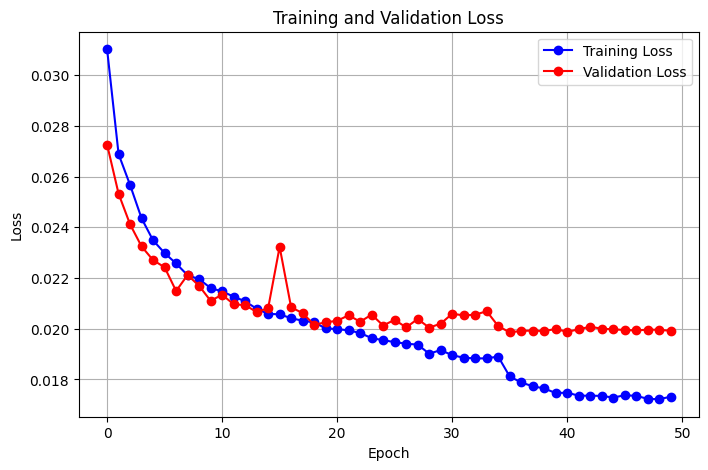

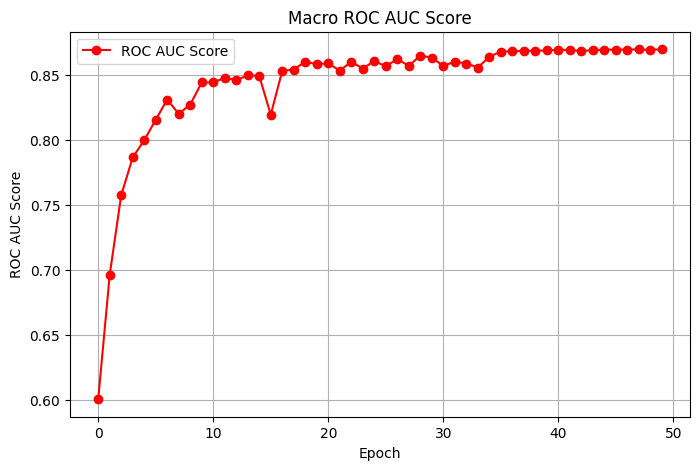

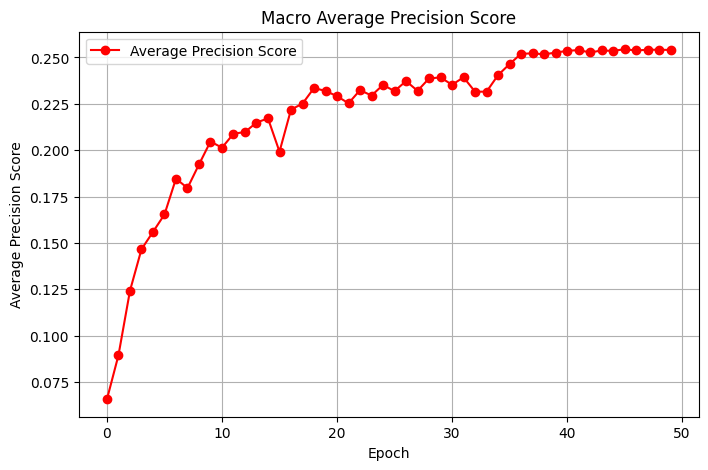


--- Starting Fold 4/5 ---
  --> Epoch 1: Best AUC Updated: 0.6123
Epoch 1 Train_loss: 0.0313 | Val_Loss: 0.0268 | Val_AUC: 0.6123| Val_avg_prec: 0.0698
  --> Epoch 2: Best AUC Updated: 0.6875
Epoch 2 Train_loss: 0.0269 | Val_Loss: 0.0248 | Val_AUC: 0.6875| Val_avg_prec: 0.0940
  --> Epoch 3: Best AUC Updated: 0.7441
Epoch 3 Train_loss: 0.0256 | Val_Loss: 0.0241 | Val_AUC: 0.7441| Val_avg_prec: 0.1111
  --> Epoch 4: Best AUC Updated: 0.7763
Epoch 4 Train_loss: 0.0246 | Val_Loss: 0.0238 | Val_AUC: 0.7763| Val_avg_prec: 0.1313
  --> Epoch 5: Best AUC Updated: 0.7882
Epoch 5 Train_loss: 0.0238 | Val_Loss: 0.0226 | Val_AUC: 0.7882| Val_avg_prec: 0.1449
  --> Epoch 6: Best AUC Updated: 0.8091
Epoch 6 Train_loss: 0.0233 | Val_Loss: 0.0222 | Val_AUC: 0.8091| Val_avg_prec: 0.1677
  --> Epoch 7: Best AUC Updated: 0.8233
Epoch 7 Train_loss: 0.0226 | Val_Loss: 0.0218 | Val_AUC: 0.8233| Val_avg_prec: 0.1753
  --> Epoch 8: Best AUC Updated: 0.8285
Epoch 8 Train_loss: 0.0222 | Val_Loss: 0.0213 | Val

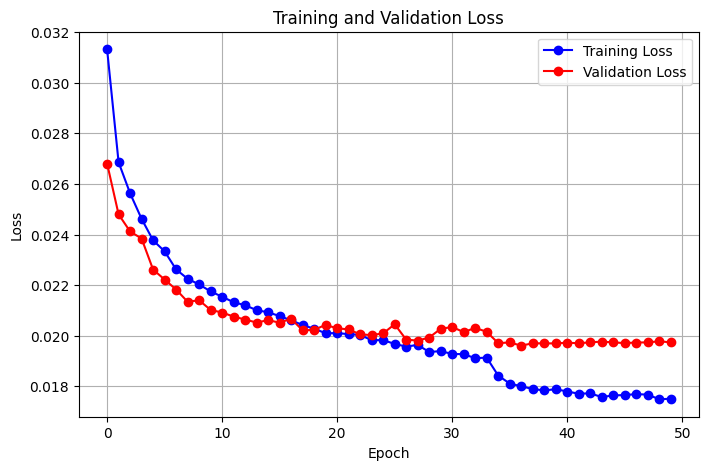

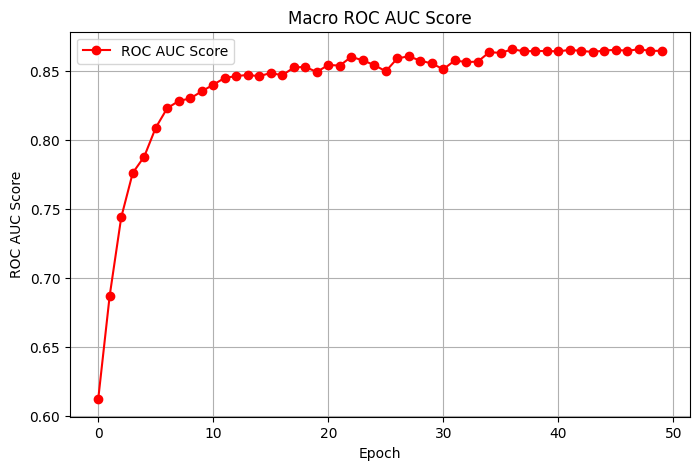

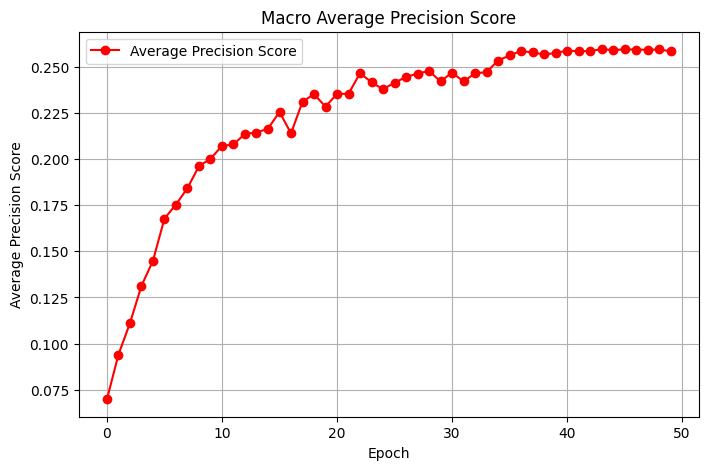


--- Starting Fold 5/5 ---
  --> Epoch 1: Best AUC Updated: 0.6424
Epoch 1 Train_loss: 0.0308 | Val_Loss: 0.0263 | Val_AUC: 0.6424| Val_avg_prec: 0.0714
  --> Epoch 2: Best AUC Updated: 0.7110
Epoch 2 Train_loss: 0.0264 | Val_Loss: 0.0253 | Val_AUC: 0.7110| Val_avg_prec: 0.1030
  --> Epoch 3: Best AUC Updated: 0.7568
Epoch 3 Train_loss: 0.0251 | Val_Loss: 0.0243 | Val_AUC: 0.7568| Val_avg_prec: 0.1186
  --> Epoch 4: Best AUC Updated: 0.7847
Epoch 4 Train_loss: 0.0242 | Val_Loss: 0.0233 | Val_AUC: 0.7847| Val_avg_prec: 0.1402
  --> Epoch 5: Best AUC Updated: 0.8096
Epoch 5 Train_loss: 0.0234 | Val_Loss: 0.0225 | Val_AUC: 0.8096| Val_avg_prec: 0.1542
  --> Epoch 6: Best AUC Updated: 0.8135
Epoch 6 Train_loss: 0.0229 | Val_Loss: 0.0223 | Val_AUC: 0.8135| Val_avg_prec: 0.1659
Epoch 7 Train_loss: 0.0224 | Val_Loss: 0.0223 | Val_AUC: 0.8120| Val_avg_prec: 0.1689
  --> Epoch 8: Best AUC Updated: 0.8253
Epoch 8 Train_loss: 0.0222 | Val_Loss: 0.0219 | Val_AUC: 0.8253| Val_avg_prec: 0.1777
  -->

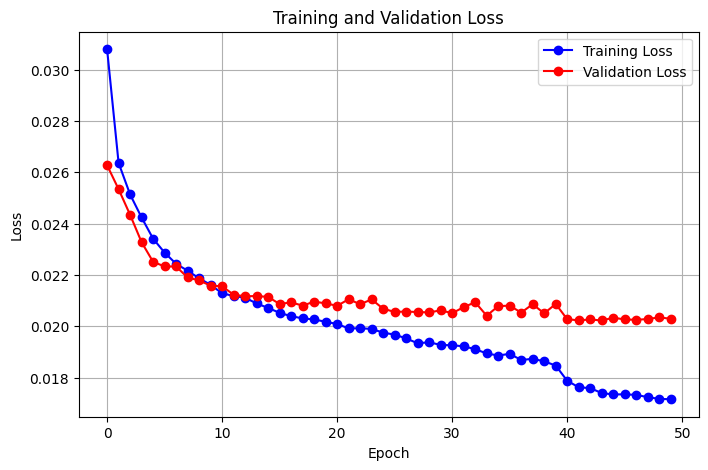

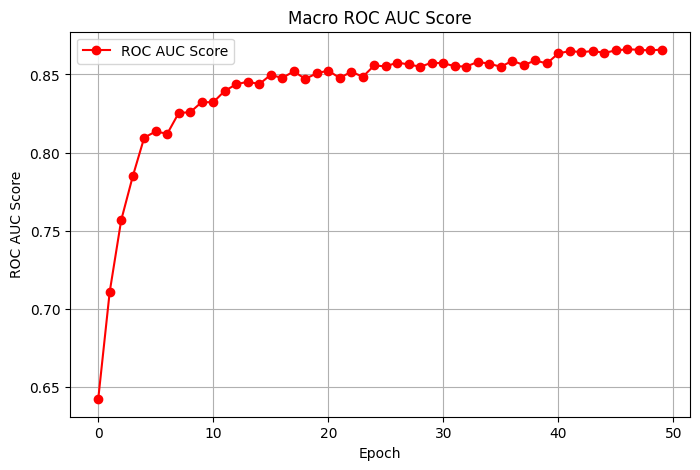

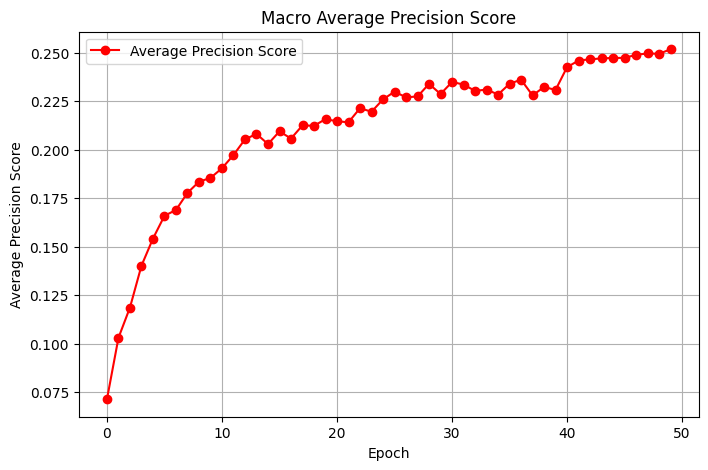

Cross-Validation complete.


In [21]:
import numpy as np
from torch.utils.data import DataLoader, Subset
from skmultilearn.model_selection import IterativeStratification

device = "cuda" if torch.cuda.is_available() else "cpu"

# Define the K-Fold splitter
k_folds = 5
stratifier = IterativeStratification(n_splits=k_folds, order=1)

# Initialize indices
indices = np.arange(len(env_train))

# Store results for Out-of-fold (OOF) analysis
oof_probs = np.zeros(species_train.shape)

for fold, (train_idx, val_idx) in enumerate(stratifier.split(env_train, species_train)):
    print(f"\n--- Starting Fold {fold+1}/{k_folds} ---")

    # Initial DataLoader setup using split=None
    full_train_data = GeoPlantDataset(tabular=env_train,images=img_train, timeseries=ts_train, labels=species_train, split=None)
    train_loader = DataLoader(Subset(full_train_data, train_idx), batch_size=32, shuffle=True)
    val_loader = DataLoader(Subset(full_train_data, val_idx), batch_size=32, shuffle=False)

    # 3. Initialize fresh model for every fold
    model = MultimodalSpeciesModel().to(device)
    criterion = MultiLabelFocalLoss(gamma=2.0, alpha=species_weights)
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

    EPOCHS = 50
    best_auc = 0
    best_model_state = None

    train_loss_list = []
    val_loss_list = []
    macro_auc_list = []
    macro_avg_prec_list = []

    for epoch in range(EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device=device)
        val_auc, val_avg_prec, val_loss = evaluate(model, val_loader, criterion, device=device)

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        macro_auc_list.append(val_auc)
        macro_avg_prec_list.append(val_avg_prec)

        scheduler.step(val_loss)

        if  val_auc > best_auc:
            best_auc = val_auc
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            print(f"  --> Epoch {epoch+1}: Best AUC Updated: {val_auc:.4f}")

        print(f"Epoch {epoch+1} Train_loss: {train_loss:.4f} | Val_Loss: {val_loss:.4f} | Val_AUC: {val_auc:.4f}| Val_avg_prec: {val_avg_prec:.4f}")

    # OOF Predictions
    print(f"Generating OOF predictions for Fold {fold+1}...")
    model.load_state_dict(best_model_state)
    fold_preds = []

    model.eval()
    with torch.no_grad():
        for img, ts, tab, y in val_loader:
            img = img.to(device).float()
            ts = ts.to(device).float()
            tab = tab.to(device).float()
            y = y.to(device).float()

            logits = model(img, ts, tab)
            probs = torch.sigmoid(logits)

            fold_preds.append(probs.cpu().numpy())

    # Store predictions in the indices corresponding to this validation fold
    oof_probs[val_idx] = np.concatenate(fold_preds, axis=0)

    model_path = f"Models/Multimodal/Best_model_fold_{fold}.pth"
    torch.save(best_model_state, model_path)
    print(f"Saved best model for Fold {fold} to {model_path}")

    plt.figure(figsize=(8,5))
    plt.plot(train_loss_list, label='Training Loss', color='blue', marker='o')
    plt.plot(val_loss_list, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    image_path = f"Models/Multimodal/Fold_{fold}_loss.png"
    plt.savefig(image_path, dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(macro_auc_list, label='ROC AUC Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC Score')
    plt.title('Macro ROC AUC Score')
    plt.legend()
    plt.grid(True)
    image_path_ROC_AUC = f"Models/Multimodal/Fold_{fold}_ROC_AUC.png"
    plt.savefig(image_path_ROC_AUC, dpi=300)
    plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(macro_avg_prec_list, label='Average Precision Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Precision Score')
    plt.title('Macro Average Precision Score')
    plt.legend()
    plt.grid(True)
    Image_path_avg_prec = f"Models/Multimodal/Fold_{fold}_avg_prec.png"
    plt.savefig(Image_path_avg_prec, dpi=300)
    plt.show()


print("Cross-Validation complete.")

## 5. Test the model

In [22]:
def ensemble_predictions(model, loader, weight_paths, device="cuda"):
    """
    1. Loads each fold model.
    2. Generates probabilities for the test set.
    3. Averages them (Ensembling).
    """
    model.to(device)
    all_fold_probs = []
    test_labels = []

    for fold_idx, path in enumerate(weight_paths):
        print(f"--> Processing Fold {fold_idx} weights...")

        # Load the saved state dict
        model.load_state_dict(torch.load(path, map_location=device, weights_only=True))
        model.eval()

        fold_probs = []
        with torch.no_grad():
            for env, ts, img, y in loader:
                env = env.to(device).float()
                ts = ts.to(device).float()
                img = img.to(device).float()


                # Get logits and convert to probabilities
                logits = model(env, ts, img)
                probs = torch.sigmoid(logits)

                fold_probs.append(probs.cpu().numpy())

                # Only collect labels once
                if fold_idx == 0:
                    test_labels.append(y.numpy())

        # Combine batches for this specific fold
        all_fold_probs.append(np.concatenate(fold_probs, axis=0))

    # Average probabilities across all folds
    ensemble_probs = np.mean(all_fold_probs, axis=0)

    # Final labels for metric calculation
    labels = np.concatenate(test_labels, axis=0)

    return ensemble_probs, labels

In [23]:
# List saved model files
fold_weight_files = [f"Models/Multimodal/Best_model_fold_{i}.pth" for i in range(5)]

# Generate the ensemble probabilities
ensemble_probs, test_labels = ensemble_predictions(
    model=MultimodalSpeciesModel(),
    loader=test_loader,
    weight_paths=fold_weight_files,
    device=device
)

--> Processing Fold 0 weights...
--> Processing Fold 1 weights...
--> Processing Fold 2 weights...
--> Processing Fold 3 weights...
--> Processing Fold 4 weights...


## 6. Evaluate the model

### 6.1 Finding best threshold using OOF analysis

In [24]:
def find_optimal_thresholds(y_true, oof_probs):
    """
    Finds the best threshold for each of the 342 species.
    y_true: Ground truth labels (N, 342)
    oof_probs: Out-of-fold predictions (N, 342)
    """
    num_species = y_true.shape[1]
    best_thresholds = np.zeros(num_species)

    # Range of thresholds to test
    thresholds = np.linspace(0, 1, 100)

    print("Optimizing thresholds for 342 species...")

    for i in range(num_species):
        species_labels = y_true[:, i]
        species_probs = oof_probs[:, i]

        # Default to 0.5
        if species_labels.sum() == 0:
            best_thresholds[i] = 0.5
            continue

        best_fbeta = -1
        best_thresh = 0.5

        for t in thresholds:
            preds = (species_probs >= t).astype(int)
            score = fbeta_score(species_labels, preds, beta=0.5, zero_division=0) # Use fbeta to raise precision

            if score > best_fbeta:
                best_fbeta = score
                best_thresh = t

        best_thresholds[i] = best_thresh

    print("Optimization complete.")
    return best_thresholds

In [25]:
opt_thresholds = find_optimal_thresholds(species_train, oof_probs)
binary_preds = (ensemble_probs >= opt_thresholds).astype(int)

Optimizing thresholds for 342 species...
Optimization complete.


### 6.2 Fully evaluating the ensemble model

In [26]:
def full_evaluation(preds, labels, opt_thresholds, binary_preds):
    macro_auc = roc_auc_score(labels, preds, average='macro')
    weighted_auc = roc_auc_score(labels, preds, average='micro')

    macro_avg_prec = average_precision_score(labels, preds, average='macro')
    weighted_avg_prec = average_precision_score(labels, preds, average='micro')

    macro_f1 = f1_score(labels, binary_preds, average='macro')
    weighted_f1 = f1_score(labels, binary_preds, average='micro')

    macro_precision = precision_score(labels, binary_preds, average='macro', zero_division=0)
    weighted_precision = precision_score(labels, binary_preds, average='micro', zero_division=0)

    macro_recall = recall_score(labels, binary_preds, average='macro')
    weighted_recall = recall_score(labels, binary_preds, average='micro')

    subset_acc = (binary_preds == labels).all(axis=1).mean()

    rank_loss = label_ranking_loss(labels, preds)

    return {
        "Macro ROC AUC": macro_auc,
        "Micro ROC AUC": weighted_auc,
        "Macro Average Precision": macro_avg_prec,
        "Micro Average Precision": weighted_avg_prec,
        "Macro Recall": macro_recall,
        "Micro Recall": weighted_recall,
        "Macro F1": macro_f1,
        "Micro F1": weighted_f1,
        "Macro Precision": macro_precision,
        "Micro Precision": weighted_precision,
        "Subset Accuracy": subset_acc,
        "Ranking Loss": rank_loss
    }


In [27]:
results = full_evaluation(ensemble_probs, test_labels, opt_thresholds, binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    print(k, ":", v)

Metrics for focal model:
Macro ROC AUC : 0.8767536453633341
Micro ROC AUC : 0.888181865568184
Macro Average Precision : 0.269206695670128
Micro Average Precision : 0.251921404940864
Macro Recall : 0.22391200909487335
Micro Recall : 0.28787408900604744
Macro F1 : 0.23439783678028286
Micro F1 : 0.31949404121671043
Macro Precision : 0.317852168870105
Micro Precision : 0.35891735137747705
Subset Accuracy : 0.017
Ranking Loss : 0.10947977616250462


# 7. Retraining model on full training dataset using hyperparameters

In [28]:
full_train_data = GeoPlantDataset(tabular=env_train,images=img_train, timeseries=ts_train, labels=species_train, split=None)
full_loader = DataLoader(full_train_data, batch_size=32, shuffle=True)

# Initialize fresh model
final_model = MultimodalSpeciesModel().to(device)
criterion = MultiLabelFocalLoss(gamma=2.0, alpha=species_weights)
optimizer = torch.optim.AdamW(final_model.parameters())

final_epochs = 45

print(f"Starting final retraining on 100% of data for {final_epochs} epochs...")

final_model.train()
for epoch in range(final_epochs):
    train_loss = train_epoch(final_model, full_loader, optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}/{final_epochs} | Loss: {train_loss:.4f}")

torch.save(final_model.state_dict(), "Models/Multimodal/Multimodal_model.pth")

Starting final retraining on 100% of data for 45 epochs...
Epoch 1/45 | Loss: 0.0301
Epoch 2/45 | Loss: 0.0261
Epoch 3/45 | Loss: 0.0248
Epoch 4/45 | Loss: 0.0239
Epoch 5/45 | Loss: 0.0230
Epoch 6/45 | Loss: 0.0225
Epoch 7/45 | Loss: 0.0221
Epoch 8/45 | Loss: 0.0218
Epoch 9/45 | Loss: 0.0216
Epoch 10/45 | Loss: 0.0214
Epoch 11/45 | Loss: 0.0212
Epoch 12/45 | Loss: 0.0210
Epoch 13/45 | Loss: 0.0208
Epoch 14/45 | Loss: 0.0208
Epoch 15/45 | Loss: 0.0206
Epoch 16/45 | Loss: 0.0202
Epoch 17/45 | Loss: 0.0203
Epoch 18/45 | Loss: 0.0203
Epoch 19/45 | Loss: 0.0202
Epoch 20/45 | Loss: 0.0200
Epoch 21/45 | Loss: 0.0200
Epoch 22/45 | Loss: 0.0200
Epoch 23/45 | Loss: 0.0198
Epoch 24/45 | Loss: 0.0197
Epoch 25/45 | Loss: 0.0197
Epoch 26/45 | Loss: 0.0195
Epoch 27/45 | Loss: 0.0194
Epoch 28/45 | Loss: 0.0193
Epoch 29/45 | Loss: 0.0193
Epoch 30/45 | Loss: 0.0192
Epoch 31/45 | Loss: 0.0191
Epoch 32/45 | Loss: 0.0190
Epoch 33/45 | Loss: 0.0189
Epoch 34/45 | Loss: 0.0189
Epoch 35/45 | Loss: 0.0187
Epoch

In [29]:
def test_merged_model(model, loader, device="cuda"):
    model.eval()
    merged_probs = []
    labels = []

    with torch.no_grad():
        for env, img, ts , y in loader:

            env = env.to(device).float()
            img = img.to(device).float()
            ts = ts.to(device).float()

            logits = model(env, img, ts)
            probs = torch.sigmoid(logits)

            merged_probs.append(probs.cpu())
            labels.append(y)

    merged_probs = torch.cat(merged_probs).numpy()
    labels = torch.cat(labels).numpy()

    return merged_probs, labels

In [30]:
merged_model_probs, test_labels = test_merged_model(model=final_model, loader=test_loader, device=device)

In [31]:
merged_model_binary_preds = (merged_model_probs >= opt_thresholds).astype(int)

In [32]:
results = full_evaluation(merged_model_probs, test_labels, opt_thresholds, merged_model_binary_preds)
print("Metrics for focal model:")
for k,v in results.items():
    print(k, ":", v)

Metrics for focal model:
Macro ROC AUC : 0.8543101438260386
Micro ROC AUC : 0.8588397139415826
Macro Average Precision : 0.23424762047407072
Micro Average Precision : 0.18829159928706435
Macro Recall : 0.19766194891617664
Micro Recall : 0.2519770507055357
Macro F1 : 0.19146569147684822
Micro F1 : 0.27238821606671415
Macro Precision : 0.260044603094842
Micro Precision : 0.29639762881896947
Subset Accuracy : 0.014
Ranking Loss : 0.1402004134534235


In [33]:
# Calculate F1 per species
from sklearn.metrics import f1_score
per_species_f1 = f1_score(test_labels, merged_model_binary_preds, average=None, zero_division=0)

# Sort them
sorted_indices = np.argsort(per_species_f1)[::-1]

print("Top 5 Species F1:", per_species_f1[sorted_indices[:5]])
print("Bottom 5 Species F1:", per_species_f1[sorted_indices[-5:]])
print("Number of species with 0.0 F1:", np.sum(per_species_f1 == 0))

Top 5 Species F1: [0.67256637 0.59701493 0.5740458  0.56060606 0.55263158]
Bottom 5 Species F1: [0. 0. 0. 0. 0.]
Number of species with 0.0 F1: 77


### Multilabel confusion matrix

In [34]:
from sklearn.metrics import multilabel_confusion_matrix

matrices = multilabel_confusion_matrix(test_labels, merged_model_binary_preds)

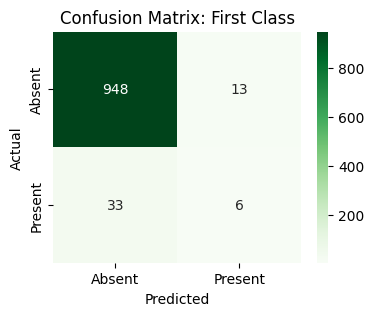

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


first_class_matrix = matrices[0]
first_class_name = "First Class"

# 3. Plot it
plt.figure(figsize=(4, 3))
sns.heatmap(first_class_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Absent', 'Present'],
            yticklabels=['Absent', 'Present'])

plt.title(f"Confusion Matrix: {first_class_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 7. Visualization on map

In [36]:
import folium
def map_predictions_species(preds, labels, species_index, test_lats, test_lons, show_types=None):
    """
    Creates a Folium map showing prediction correctness for a specific species.

    Parameters:
    - all_preds: np.array of shape (num_samples, num_species), model predictions (0/1)
    - all_labels: np.array of shape (num_samples, num_species), true labels (0/1)
    - species_index: int, index of the species to visualize
    - test_lats: list or array of latitude values
    - test_lons: list or array of longitude values
    - show_types: set of strings indicating which prediction types to show.
                  Options: 'TP', 'TN', 'FP', 'FN'
                  Default: None (show all)
    """

    print("Number of species prediction:")
    print(preds[:,species_index].sum())
    print("Number of species occurence:")
    print(labels[:,species_index].sum())

    if show_types is None:
        show_types = {'TP', 'TN', 'FP', 'FN'}  # show all by default

    center_lat = np.mean(test_lats)
    center_lon = np.mean(test_lons)
    fmap = folium.Map(location=[center_lat, center_lon], zoom_start=4)

    preds_species = preds[:, species_index]
    labels_species = labels[:, species_index]

    for lat, lon, pred, label in zip(test_lats, test_lons, preds_species, labels_species):
        # Determine prediction type and color
        if pred == 1 and label == 1:
            pred_type = 'TP'
            color = 'green'
        elif pred == 0 and label == 1:
            pred_type = 'FN'
            color = 'red'
        elif pred == 0 and label == 0:
            pred_type = 'TN'
            color = 'blue'
        else:  # pred == 1 and label == 0
            pred_type = 'FP'
            color = 'orange'

        if pred_type not in show_types:
            continue  # skip this point if not in selected types

        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6
        ).add_to(fmap)

    return fmap

In [37]:
map_predictions_species(preds=binary_preds, labels=test_labels, species_index=15, test_lats=test_lats, test_lons=test_lons)

Number of species prediction:
207
Number of species occurence:
250.0


In [41]:
def get_modality_importance(model, img, ts, tab, species_id, device):

    img = img.to(device).float()
    ts  = ts.to(device).float()
    tab = tab.to(device).float()

    img.requires_grad = True
    ts.requires_grad  = True
    tab.requires_grad = True

    model.eval()
    logits = model(img, ts, tab)
    target_logit = logits[:, species_id].mean()

    model.zero_grad()
    target_logit.backward()

    # gradient × input
    gxi_img = (img * img.grad).detach()
    gxi_ts  = (ts  * ts.grad).detach()
    gxi_tab = (tab * tab.grad).detach()

    # reduce to scalar importance
    score_img = gxi_img.abs().mean(dim=(1,2,3))   # (batch,)
    score_ts  = gxi_ts.abs().mean(dim=(1,2))      # (batch,)
    score_tab = gxi_tab.abs().mean(dim=1)         # (batch,)

    return score_img.cpu(), score_ts.cpu(), score_tab.cpu()


In [42]:
def compute_modality_importance_across_species(model, test_loader, num_species, device="cuda"):

    # store importance scores for each species
    modality_importance = {
        "image":   np.zeros(num_species),
        "ts":      np.zeros(num_species),
        "tabular": np.zeros(num_species),
        "counts":  np.zeros(num_species)  # count samples where species appears
    }

    for img, ts, tab, labels in test_loader:

        labels = labels.numpy()  # shape: (batch, 342)

        for s in range(num_species):
            if labels[:, s].sum() == 0:
                continue  # skip species not present in this batch

            img_s, ts_s, tab_s = img.clone(), ts.clone(), tab.clone()

            imp_img, imp_ts, imp_tab = get_modality_importance(
                model, img_s, ts_s, tab_s, s, device
            )

            modality_importance["image"][s]   += imp_img.mean().item()
            modality_importance["ts"][s]      += imp_ts.mean().item()
            modality_importance["tabular"][s] += imp_tab.mean().item()
            modality_importance["counts"][s]  += 1

    # average by number of samples
    for key in ["image", "ts", "tabular"]:
        modality_importance[key] /= (modality_importance["counts"] + 1e-9)

    return modality_importance

In [43]:
num_species = 342

model = MultimodalSpeciesModel().to(device)
modality_scores = compute_modality_importance_across_species(
    model, test_loader, num_species, device
)


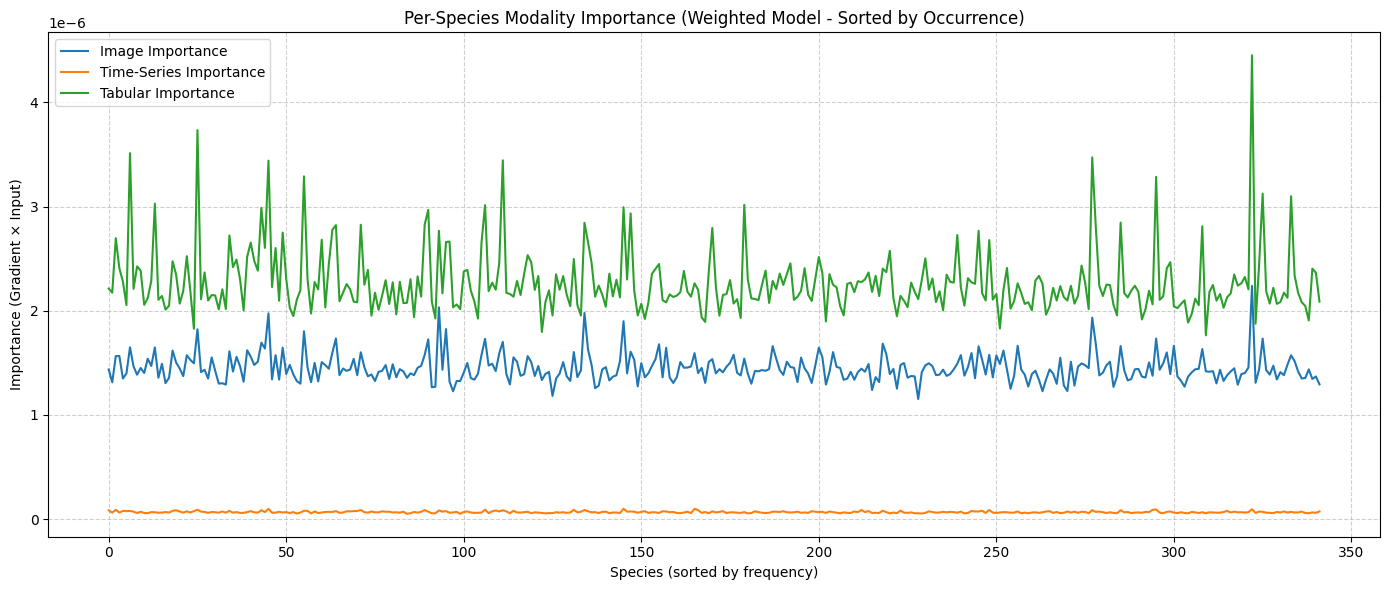

In [ ]:
# Rearrange modality scores
rearranged_img_importance = np.array(modality_scores["image"])[sorted_indices]
rearranged_ts_importance = np.array(modality_scores["ts"])[sorted_indices]
rearranged_tab_importance = np.array(modality_scores["tabular"])[sorted_indices]

# Single subplot
fig, ax = plt.subplots(figsize=(14, 6))  # smaller height is usually enough

# Plot modality importance
ax.plot(rearranged_img_importance, label="Image Importance")
ax.plot(rearranged_ts_importance, label="Time-Series Importance")
ax.plot(rearranged_tab_importance, label="Tabular Importance")

ax.set_title("Per-Species Modality Importance (Sorted by Occurrence)")
ax.set_ylabel("Importance (Gradient × Input)")
ax.set_xlabel("Species (sorted by frequency)")
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("Models/Multimodal/Modality_importance.png", dpi=300)
plt.show()